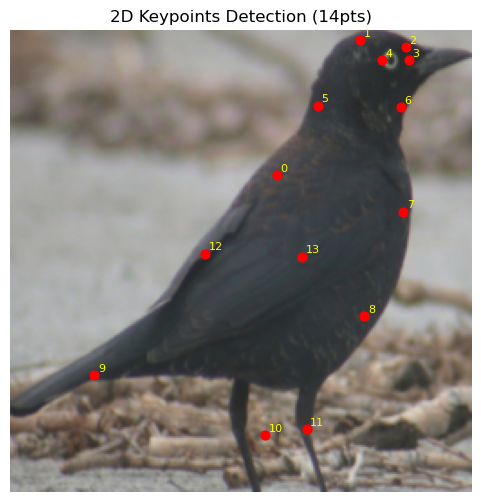

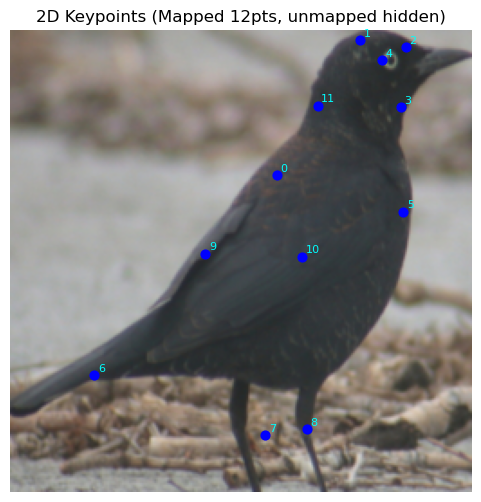

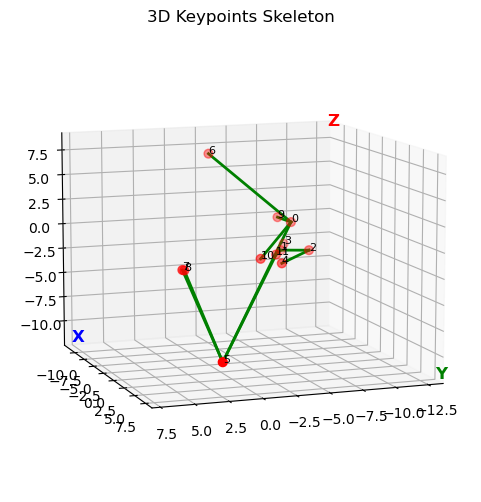

In [4]:
# ==============================================
# Demo: Single image -> Key Point Detector -> Regressioner -> BirdModel -> Visualization (Add 14→12 mapping + alignment)
# ==============================================
import os, json, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------- change the path --------
DET_CKPT   = r"D:\bishe\w3_net_model\best_model.pth"       
REG_CKPT   = r"D:\bishe\re_out\regressor_best.pth"          
PATH_JSON  = r"D:\bishe\avian\bird_eccv.json"               
PATH_PRIOR = r"D:\bishe\avian\pose_bone_prior.pth"          
IMG_PATH   = r"D:\bishe\data_nor_14_w3\000570\image.png"    # image path

IMG_SIZE = (256, 256)
NUM_KPTS = 14
NUM_MODEL_KPTS = 12




# ==============================================
# # Utility Functions
# ==============================================
def rot6d_to_rotmat(x: torch.Tensor) -> torch.Tensor:
    B = x.shape[0]; x = x.view(B, -1, 6)
    a1 = x[..., :3]; a2 = x[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * (a2*b1).sum(dim=-1, keepdim=True)), dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    return torch.stack([b1, b2, b3], dim=-2)

def set_axes_equal(ax):
    x_limits=ax.get_xlim3d(); y_limits=ax.get_ylim3d(); z_limits=ax.get_zlim3d()
    x_range=abs(x_limits[1]-x_limits[0]); x_mid=np.mean(x_limits)
    y_range=abs(y_limits[1]-y_limits[0]); y_mid=np.mean(y_limits)
    z_range=abs(z_limits[1]-z_limits[0]); z_mid=np.mean(z_limits)
    r=0.5*max([x_range,y_range,z_range])
    ax.set_xlim3d([x_mid-r,x_mid+r]); ax.set_ylim3d([y_mid-r,y_mid+r]); ax.set_zlim3d([z_mid-r,z_mid+r])

def umeyama_align_3d_to_2d(P3, U2, valid=None, try_mirror=True):
    N = P3.shape[0]
    if valid is None:
        valid = np.ones(N, dtype=bool)
    idx = np.where(valid)[0]
    Y = np.hstack([U2[idx], np.zeros((len(idx), 1))])  # (M,3)

    def fit_once(X3):
        X = X3[idx]
        muX, muY = X.mean(0), Y.mean(0)
        Xc, Yc = X - muX, Y - muY
        Cov = (Yc.T @ Xc) / len(idx)                   # (3x3)
        U, S, Vt = np.linalg.svd(Cov)
        D = np.eye(3); D[2,2] = np.sign(np.linalg.det(U @ Vt))
        R = U @ D @ Vt
        varX = (Xc**2).sum() / len(idx)
        s = np.trace(np.diag(S) @ D) / max(varX, 1e-8)
        t = muY - s * (muX @ R.T)
        # 重投影误差（仅 XY）
        U_pred = (s * (X3 @ R.T) + t)[:, :2]
        rmse = np.sqrt(((U_pred[idx] - U2[idx])**2).sum(axis=1).mean())
        P_cam = X3 @ R.T  
        return P_cam, R, s, t, rmse

    P_cam, R, s, t, rmse = fit_once(P3)
    if try_mirror:
        Pm = P3.copy(); Pm[:,0] *= -1  # 左右镜像
        Pm_cam, Rm, sm, tm, rmsem = fit_once(Pm)
        if rmsem < rmse:
            return Pm_cam, Rm, sm, tm, rmsem
    return P_cam, R, s, t, rmse

# ==============================================
# Model Definition
# ==============================================

# ----- Key point detector -----
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x): return x * self.fc(x)

class KeypointFPNRegressor(nn.Module):
    def __init__(self, num_keypoints=14):
        super().__init__()
        self.num_keypoints = num_keypoints
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  
        self.layer1 = nn.Sequential(*list(self.backbone.children())[:5])
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        self.up2 = nn.ConvTranspose2d(2048, 512, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(512+1024, 256, kernel_size=2, stride=2)
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(256+512, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True), SEBlock(256),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,128), nn.ReLU(inplace=True),
            nn.Linear(128,num_keypoints*2), nn.Sigmoid()
        )
    def forward(self, x):
        x1=self.layer1(x); x2=self.layer2(x1); x3=self.layer3(x2); x4=self.layer4(x3)
        x=self.up2(x4); x=torch.cat([x,x3],dim=1)
        x=self.up1(x); x=torch.cat([x,x2],dim=1)
        x=self.fusion_conv(x)
        out=self.head(x)
        return out.view(-1,self.num_keypoints,2)

# ----- Regressor -----
class PoseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(nn.Linear(36,512),nn.BatchNorm1d(512),nn.ReLU())
        self.layer2=nn.Sequential(nn.Linear(512,512),nn.BatchNorm1d(512),nn.ReLU())
        self.final=nn.Linear(512,25*6+3)
    def forward(self,x): return self.final(self.layer2(self.layer1(x)))

class ShapeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(nn.Conv2d(1,8,5,2,2),nn.BatchNorm2d(8),nn.ReLU(),nn.MaxPool2d(2,2))
        self.layer2=nn.Sequential(nn.Conv2d(8,8,3,1,1),nn.BatchNorm2d(8),nn.ReLU(),nn.MaxPool2d(2,2))
        self.layer3=nn.Sequential(nn.Conv2d(8,16,3,1,1),nn.BatchNorm2d(16),nn.ReLU(),nn.MaxPool2d(2,2))
        self.layer4=nn.Sequential(nn.Conv2d(16,32,3,1,1),nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(2,2))
        self.layer5=nn.Sequential(nn.Conv2d(32,64,3,1,1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2,2))
        self.gap=nn.AdaptiveAvgPool2d(1); self.fc=nn.Linear(64,24)
    def forward(self,x): return self.fc(self.gap(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))).flatten(1))

class Regressor(nn.Module):
    def __init__(self): super().__init__(); self.pose_head=PoseNet(); self.shape_head=ShapeNet()
    def forward(self,k36,mask): return self.pose_head(k36),self.shape_head(mask)
    def postprocess(self,pt,bone): R=rot6d_to_rotmat(pt[:,:-3]); t=pt[:,-3:]; return R,t,bone

# ----- BirdModel -----
class LBS:
    def __init__(self,J,parents,weights):
        self.n_joints=J.shape[1]
        self.h_joints=F.pad(J.unsqueeze(-1),[0,0,0,1],value=0)
        self.kin_tree=torch.cat([J[:,[0],:],J[:,1:]-J[:,parents[1:]]],dim=1).unsqueeze(-1)
        self.parents=parents; self.weights=weights[None].float()
    def __call__(self,V,pose,bone,scale):
        B=V.shape[0]; V=F.pad(V.unsqueeze(-1),[0,0,0,1],value=1)
        kin_tree=(scale*self.kin_tree)*bone[:,:,None,None]
        T=torch.zeros([B,self.n_joints,4,4],device=V.device,dtype=V.dtype)
        T[:,:, -1,-1]=1; T[:,:,:3,:]=torch.cat([pose,kin_tree],dim=-1)
        T_rel=[T[:,0]]
        for i in range(1,self.n_joints): T_rel.append(T_rel[self.parents[i]]@T[:,i])
        T_rel=torch.stack(T_rel,dim=1)
        T_rel[:,:,:,[-1]]-=T_rel.clone()@(self.h_joints*scale)
        T_=self.weights@T_rel.view(B,self.n_joints,-1); T_=T_.view(B,-1,4,4)
        V=T_@V; return V[:,:,:3,0]

class BirdModel:
    def __init__(self,json_path,prior_path=None,device="cpu"):
        with open(json_path,"r") as f: dd=json.load(f)
        self.parents=torch.tensor(dd["kintree_table"][0],device=device,dtype=torch.long)
        self.weights=torch.tensor(dd["weights"],device=device).float()
        self.vert2kpt=torch.tensor(dd["vert2kpt"],device=device).float()
        self.J=torch.tensor(dd["J"],device=device).unsqueeze(0).float()
        self.V=torch.tensor(dd["V"],device=device).unsqueeze(0).float()
        self.LBS=LBS(self.J,self.parents,self.weights)
        self.n_joints=self.J.shape[1]
    def __call__(self,global_R,body_R,bone,scale=1.0):
        B=global_R.shape[0]
        V=(self.V*scale).repeat([B,1,1]).float()
        pose=torch.cat([global_R.float(),body_R.float()],dim=1)
        bone=torch.cat([torch.ones([B,1],device=V.device),bone.float()],dim=1)
        verts=self.LBS(V,pose,bone,scale)
        k3d=torch.einsum("kv,bvd->bkd",self.vert2kpt,verts)
        return {"vertices":verts,"keypoints":k3d}

# ==============================================
# Load model
# ==============================================
det=KeypointFPNRegressor(num_keypoints=NUM_KPTS).to(DEVICE)
sd_det = torch.load(DET_CKPT, map_location=DEVICE)
det.load_state_dict(sd_det.get("model", sd_det), strict=False); det.eval()

reg=Regressor().to(DEVICE)
sd_reg=torch.load(REG_CKPT,map_location=DEVICE)
reg.load_state_dict(sd_reg.get("model_state_dict", sd_reg), strict=False); reg.eval()

bird=BirdModel(PATH_JSON,PATH_PRIOR,device=DEVICE)

# ==============================================
# Forward reasoning
# ==============================================
transform=T.Compose([
    T.Resize(IMG_SIZE),T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
mask_transform=T.Compose([T.Resize((64,64)),T.ToTensor()])

img=Image.open(IMG_PATH).convert("RGB")
mask=img.convert("L") # 

x_det=transform(img).unsqueeze(0).to(DEVICE)
x_mask=mask_transform(mask).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    kpts=det(x_det)[0].cpu().numpy()   # (14,2)，
    DET_TO_REG = {
        0: 0,
        1: 1,   # crown
        2: 2,   # forehead
        4: 4,   # right_eye
        5: 11,  # nape
        7: 5,   # breast
        9: 6,   # tail
        10: 7,  # left_leg
        11: 8,  # right_leg
        12: 9,  # left_wing
        13: 10, # right_wing
        6: 3,
        # 0 (back), 3 (L-eye), 6 (throat), 8 (belly)  
    }

    k12_det = np.zeros((NUM_MODEL_KPTS, 2), dtype=np.float32)
    valid12_mask = np.zeros((NUM_MODEL_KPTS,), dtype=bool)
    for det_idx, reg_idx in DET_TO_REG.items():
        k12_det[reg_idx] = kpts[det_idx]
        valid12_mask[reg_idx] = True

    k36=np.zeros(36,np.float32); k36[:28]=kpts.reshape(-1)
    k36_t=torch.from_numpy(k36).unsqueeze(0).to(DEVICE).float()
    pt,bone=reg(k36_t,x_mask)
    R,t,bone=reg.postprocess(pt,bone)
    out=bird(R[:,:1],R[:,1:],bone,scale=1.0)
    k3d=out["keypoints"][0].cpu().numpy()

# ==============================================
# Visualization
# ==============================================

# ----2D Key Points （14kps） ----
W,H=img.size
kpts_px=kpts*np.array([W,H])
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.scatter(kpts_px[:,0],kpts_px[:,1],c="r",s=40)
for i,(x,y) in enumerate(kpts_px): plt.text(x+2,y-2,str(i),color="yellow",fontsize=8)
plt.title("2D Keypoints Detection (14pts)"); plt.axis("off"); plt.show()

# ---- 2D Key Points （12kps）----
k12_px = k12_det * np.array([W, H], dtype=np.float32)
plt.figure(figsize=(6,6))
plt.imshow(img)

for i, (x, y) in enumerate(k12_px):
    if not valid12_mask[i]:
        continue  
    plt.scatter(x, y, c="b", s=40)
    plt.text(x+2, y-2, str(i), color="cyan", fontsize=8)

plt.title("2D Keypoints (Mapped 12pts, unmapped hidden)")
plt.axis("off")
plt.show()

# ---- 3Dskeleton ----

E12=[(2,1),(1,11),(2,4),(11,5),(5,0),(0,6),(0,9),(0,10),(5,7),(5,8)]
fig=plt.figure(figsize=(6,6)); ax=fig.add_subplot(111,projection="3d")
for i,j in E12:
    xs,ys,zs=k3d[[i,j],0],k3d[[i,j],1],k3d[[i,j],2]
    ax.plot(xs,ys,zs,c="g",lw=2)


ax.scatter(k3d[:,0],k3d[:,1],k3d[:,2],c="r",s=40)
for i,(x,y,z) in enumerate(k3d):
    ax.text(x,y,z,str(i),fontsize=8,color="k")

ax.set_title("3D Keypoints Skeleton")
ax.view_init(elev=10,azim=70)
set_axes_equal(ax)

# ======  XYZ  ======
xlim, ylim, zlim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
ax.text(xlim[1], ylim[0], zlim[0], 'X', color='blue', fontsize=12, weight='bold')
ax.text(xlim[0], ylim[1], zlim[0], 'Y', color='green', fontsize=12, weight='bold')
ax.text(xlim[0], ylim[0], zlim[1], 'Z', color='red', fontsize=12, weight='bold')

plt.show()

